## Imports

In [1]:
import os
import sys
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import time

In [2]:
# import the frank2d directory
current_dir =  os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

from frank2d import Frank2D 
from constants import rad_to_arcsec
from plot import Plot
from fitting import IterativeSolverMethod

# frank1d
import frank
from frank.geometry import FixedGeometry, SourceGeometry, FitGeometryGaussian
from frank.radial_fitters import FrankFitter
from frank.utilities import UVDataBinner

from scipy.sparse.linalg._interface import LinearOperator
from scipy.sparse.linalg._isolve.utils import make_system
from scipy.stats import binned_statistic

## Functions

In [3]:
def deproject(u, v, inc, PA, inverse=False):
    r"""
    Deproject the image in visibily space

    Parameters
    ----------
    u : array of real, size = N, unit = :math:`\lambda`
        u-points of the visibilities
    v : array of real, size = N, unit = :math:`\lambda`
        v-points of the visibilities
    inc : float, unit = deg
        Inclination
    PA : float, unit = deg
        Position angle, defined east of north.
    inverse : bool, default=False
        If True, the uv-points are reprojected rather than deprojected

    Returns
    -------
    up : array, size = N, unit = :math:`\lambda`
        Deprojected u-points
    vp : array, size = N, unit = :math:`\lambda`
        Deprojected v-points
    wp : array of real, size = N, unit = :math:`\lambda`
        Fourier w-points of the deprojected visibilities. Only returned if
        deprojecting.

    """
    deg_to_rad = np.pi / 180
    inc *= deg_to_rad
    PA *= deg_to_rad

    cos_t = np.cos(PA)
    sin_t = np.sin(PA)

    if inverse:
        sin_t *= -1
        u = u / np.cos(inc)

    up = u * cos_t - v * sin_t
    vp = u * sin_t + v * cos_t

    if inverse:
        return up, vp
    else:
    #   Deproject
        wp = up * np.sin(inc)
        up = up * np.cos(inc)

        return up, vp, wp

In [58]:
def get_radial_profile(frank_object):
    x = frank_object._FT._Xn*rad_to_arcsec
    y = frank_object._FT._Yn*rad_to_arcsec
    pixel_size = (x[1]-x[0])
    r = np.hypot(x, y)
    I = frank_object.sol_intensity
    r = r.flatten()
    I = I.flatten()
    N = frank_object._Nx
    bin = (np.max(r) - np.min(r))/N
    I_binned, bin_edges, _ = binned_statistic(r, I, 'mean', N)
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return r_centers, I_binned

def get_vis_profile(frank_object):
    u = frank_object._FT._Un
    v = frank_object._FT._Vn
    pixel_size = (u[1]-u[0])
    q = np.hypot(u, v)
    print(len(q))
    Vis = frank_object.sol_visibility
    print(len(Vis))
    q = q.flatten()
    Vis = Vis.flatten()
    N = frank_object._Nx
    bin = (np.max(q) - np.min(q))/N
    weights_gridded = frank_object._gridded_data['weights']
    Vis_binned, bin_edges, _ = binned_statistic(q, Vis, 'mean', N)
    Vis_Weights_binned, bin_edges, _ = binned_statistic(q, Vis*weights_gridded, 'sum', N)
    Weights_binned, bin_edges, _ = binned_statistic(q, weights_gridded, 'sum', N)
    q_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return q_centers, Vis_Weights_binned/Weights_binned

## Upload input

In [31]:
# Huang 2018 
inc = 34.97
pa = 85.76
dra = 1.9e-3
ddec = -2.5e-3
Rout = 1.9 #arcsecs

# UVtable
dir = "../../../data/"
data_file = dir +'AS209_continuum_prom_1chan_30s_keepflagsFalse.txt'

 # load data
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)
Vis = Re + Imag*1j

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
u_deproj, v_deproj, vis_deproj = geom.apply_correction(u, v, Vis)

## Frank1D

In [32]:
# Frank Parameters
n_pts = 300
alpha = 1.3
w_smooth = 1e-1

In [33]:
geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)

In [34]:
FF = FrankFitter(Rout, n_pts, geom, alpha = alpha, weights_smooth = w_smooth)

In [35]:
sol = FF.fit(u, v, Vis, Weights)

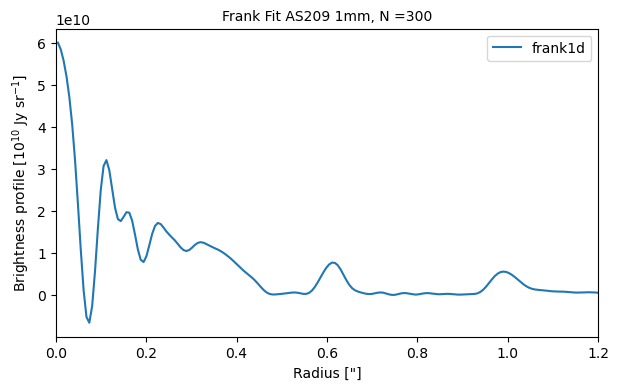

In [36]:
plt.figure(figsize = (7, 4))
plt.plot(sol.r, sol.mean,label ='frank1d')
plt.xlabel('Radius ["]', size = 10)
plt.ylabel(r'Brightness profile [$10^{10}$ Jy sr$^{-1}$]', size = 10)
plt.title('Frank Fit AS209 1mm, N =' + str(n_pts), size = 10)
plt.xlim(0, 1.2)
plt.legend()
plt.show()

## Frank2D

In [37]:
N = 300
l = 1e4
m = -0.33
c = -0.1

In [38]:
frank2d = Frank2D(N, Rout)

In [44]:
frank2d.preprocess_vis(u, v, Vis, Weights)
u_gridded, v_gridded = frank2d._gridded_data["u"], frank2d._gridded_data['v']
vis_gridded, weights_gridded = frank2d._gridded_data["vis"], frank2d._gridded_data['weights']
q = np.hypot(u, v)
len(q)

  --> time = 0.01  min |  0.49 seconds


977774

In [40]:
vis_fit_1d = sol.predict(u_gridded, v_gridded)

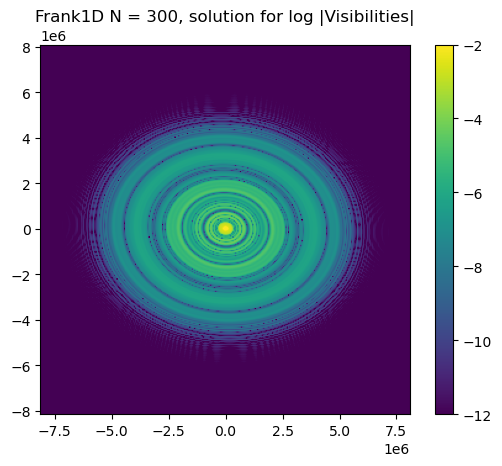

In [51]:
extent=[u_gridded.min(), u_gridded.max(), v_gridded.min(), v_gridded.max()]
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_fit_1d.real.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.title(f'Frank1D N = {N}, solution for log |Visibilities|')
plt.colorbar()

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_97973/2256721134.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)


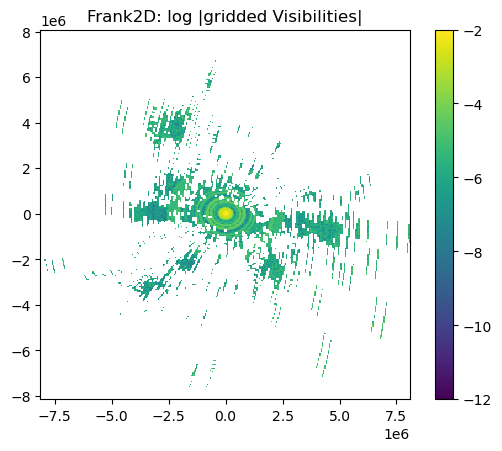

In [45]:
plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.title(f'Frank2D: log |gridded Visibilities|')
plt.colorbar()

In [122]:
len(np.unique(vis_fit_1d))

10000

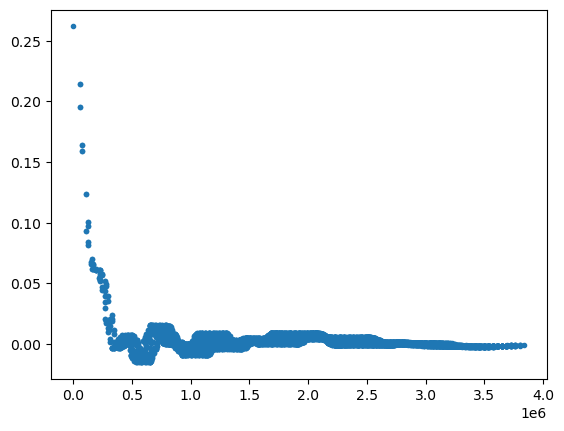

In [123]:
plt.plot(q, vis_fit_1d, ls = 'None', marker = '.')

In [50]:
start_time = time.time()

#####
frank2d = Frank2D(N, Rout, geometry = [inc, pa, dra, ddec])
frank2d.fit(u_deproj, v_deproj, vis_deproj, Weights, kernel_params=[m, c, l], method = 'cg', rtol = '1e-15', frank1d_guess = True)
#####
print("-------------------------------------- \n")
end_time = time.time()
execution_time = end_time - start_time
print(f'TOTAL TIME = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Gridding...
  --> time = 0.01  min |  0.49 seconds
Setting guess with Frank1D ...
Setting guess...
Setting fit with cg ...
Setting kernel...SquareExponential, with params: [-0.33, -0.1, 10000.0]
Fitting...
  *  Constructing linear operators...
     --> time = 7.82  min |  469.32 seconds
  *  Solving linear system...
         * rtol: 1e-15
         * final tolerance: 9.830446421948307e-08
maxiter:  20
iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
  --> CGM converged in  4  iterations
     --> time = 13.70  min |  822.20 seconds
  --> CGM converged?   True
  --> Fit correctly?   True
                                    !!!!!!!!!!!!!!!!!!!
Inverting with 2fft ...
  --> time = 0.00  min |  0.00 seconds
-------------------------------------- 

TOTAL TIME = 24.00  min |  1439.70 seconds


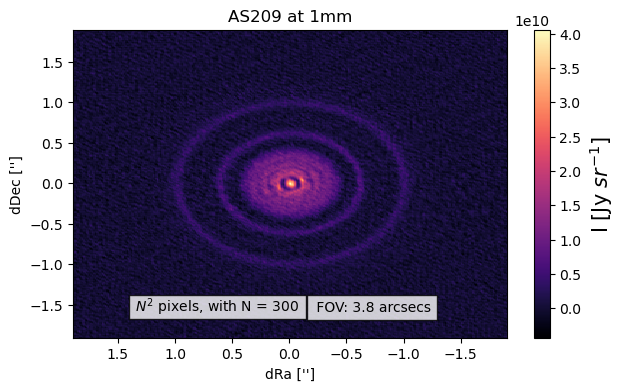

In [52]:
Plot(frank2d).get_image('AS209 at 1mm')

In [53]:
r, I = get_radial_profile(frank2d)

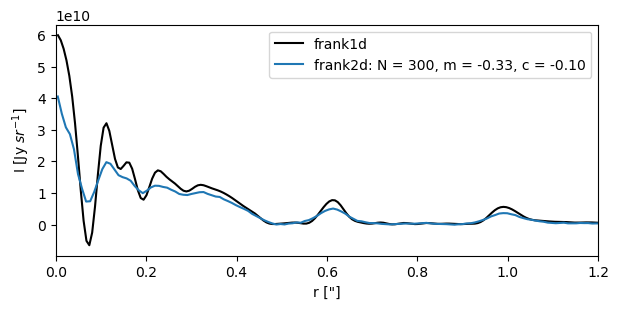

In [54]:
plt.figure(figsize=(7,3))
plt.plot(sol.r, sol.mean, 'black',label ='frank1d')
plt.plot(r, I, label = f'frank2d: N = {N}, m = {m:.2f}, c = {c:.2f}')
plt.xlabel('r ["]')
plt.xlim(0, 1.2)
plt.ylabel(r'I [Jy $sr^{-1}$]')
plt.legend()
plt.show()

90000
90000


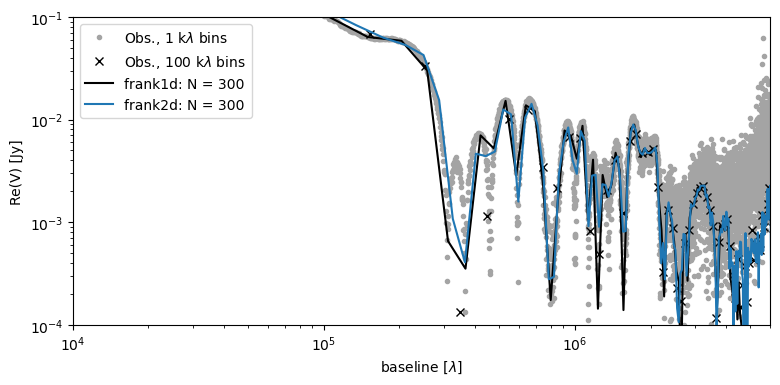

In [59]:
cs, ms = ['#a4a4a4', 'k'], ['.', 'x']
bin_widths=[1e3, 1e5]
baselines = np.hypot(u_deproj, v_deproj)         
grid = np.logspace(np.log10(min(baselines.min(), baselines[0])),
                           np.log10(max(baselines.max(), baselines[-1])),
                           10**4)

plt.figure(figsize=(9,4))

for i in range(len(bin_widths)):
            binned_vis = UVDataBinner(baselines, vis_deproj, Weights, bin_widths[i])
            plt.plot(binned_vis.uv, np.abs(binned_vis.V), c=cs[i],
                         marker=ms[i], ls='None', 
                         label=r'Obs., {:.0f} k$\lambda$ bins'.format(bin_widths[i]/1e3))

# gridded data from frank2d
u_gridded = frank2d._gridded_data['u']
v_gridded = frank2d._gridded_data['v']
vis_gridded = frank2d._gridded_data['vis']
#plt.plot(np.hypot(u_gridded, v_gridded), np.abs(vis_gridded.real),  marker='.', ls='None', c = 'pink', label =f'gridded vis')

weights_gridded = frank2d._gridded_data['weights']
baselines_gridded = np.hypot(u_gridded, v_gridded)
binned_vis_gridded = UVDataBinner(baselines_gridded, vis_gridded, weights_gridded, bin_widths[1])
#binned_vis_gridded = UVDataBinner(baselines_gridded, vis_gridded, np.ones_like(weights_gridded), bin_widths[1])

#frank1d not binned
vis_fit_1d = sol.predict_deprojected(sol.q)
baselines_fit_1d = sol.q
plt.plot(baselines_fit_1d, np.abs(vis_fit_1d), color = "black", label =f'frank1d: N = {300}')

# frank2d
q, Vis = get_vis_profile(frank2d)
plt.plot(q, np.abs(Vis.real), label = f'frank2d: N = {N}')

#plt.plot(binned_vis_gridded.uv, np.abs(binned_vis_gridded.V),  marker='.', ls='None', c = 'yellow', label = 'vis gridded frank2d')


plt.xlabel(r'baseline [$\lambda$]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4, 0.1)
plt.xlim(1e4, 6e6)
plt.ylabel('Re(V) [Jy]', size = 10)
plt.legend()
plt.show()

In [61]:
u_gridded, v_gridded = frank2d._gridded_data["u"], frank2d._gridded_data['v']
vis_gridded, weights_gridded = frank2d._gridded_data["vis"], frank2d._gridded_data['weights']

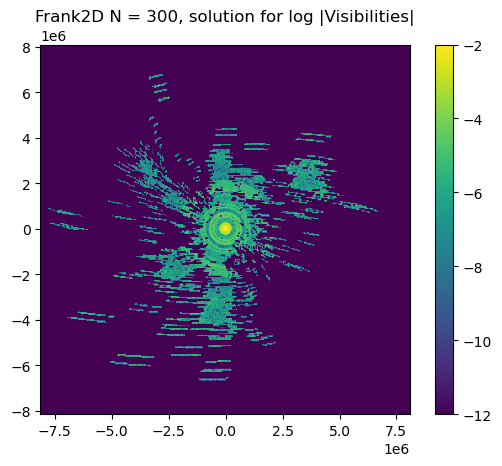

In [62]:
extent=[u_gridded.min(), u_gridded.max(), v_gridded.min(), v_gridded.max()]
plt.imshow(np.log(np.abs(np.fft.fftshift(frank2d.sol_visibility.real.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.title(f'Frank2D N = {N}, solution for log |Visibilities|')
plt.colorbar()

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_97973/2256721134.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)


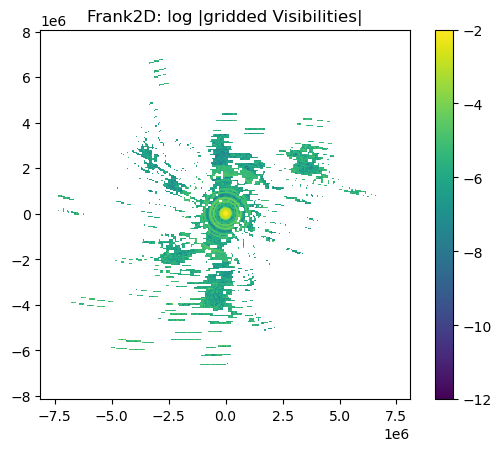

In [63]:
plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.title(f'Frank2D: log |gridded Visibilities|')
plt.colorbar()